<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Code/Random_forests_pretrained_CNN_Indo_habitat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random forest classifiers**

This script splits the data into the same train/val/test sets as used for the pretrained CNN and trained CNN. It then trains on the training data and generates the accuracy for the validation data 50 times. The best performing model of the 50 repeats is used to inference on the test data and this accuracy is reported. This proces is repeatd 100 times to generate an accuracyfor all train/val/test split combinations. A confusion matrix of all these is then generated.

In [11]:
# imports, probably some redundant packages
import sklearn
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
# Uppload the csv of features and copy the path
path = "Results/pretrained_CNN_features_10.14.04.csv"
num_classes = 2
labels = ['Healthy','Degraded']

In [4]:
data = pd.read_csv (path) #load dataframe
temp_df = data.reset_index() #put index in order
temp_df = temp_df.iloc[: , 2:] #remove unnecessary index
temp_df = temp_df.T #transpose to match indices format
temp_df = temp_df.reset_index() #re-add the index
df = temp_df.rename(columns={"index": "minute"})
print(df['minute'][:3])

0    SaF1.1733D.1677983769.180827.2.16T17.33.00.00A...
1    SaF1.1733D.1677983769.180827.2.16T17.34.00.00A...
2    SaF1.1733D.1677983769.180827.2.16T17.35.00.00A...
Name: minute, dtype: object


In [5]:
def put_files_in_splits(train_deployments, val_deployments, test_deployments):
  '''This block uses the ID's of the train, val and test sets generated above
  to select the actual recordings. This generates:
  train_files
  val_files
  test_files
  Which are the arrays of recordings corresponding to each of these '''


  #now select all files in dir that have these ID's in their name
  train_files = []
  val_files = []
  test_files = []


  #for f in all_files: #I set this above 

  for index, row in df.iterrows():
    filename = (df['minute'][index]) 
    
    #print(f)
    namePt1 = filename.split(".")[0]
    namePt2 = filename.split(".")[1]
    ID = namePt1 + '.' + namePt2
    #print(ID)
    if ID in train_deployments:
      train_files.append(filename)
    if ID in val_deployments:
      val_files.append(filename)
    if ID in test_deployments:
      test_files.append(filename)


 # print('Number and list of validation files:')
 # print(len(val_files))
 # print(val_files)
 # print('Number and list of test files:')
 # print(len(test_files))
 # print(test_files)
 # print('Number and list of training files:')
 # print(len(train_files))
 # print(train_files)
  return train_files, val_files, test_files

In [6]:
# Get the final lists of the train, val and test files for each class (e.g healthy and degraded)

def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    t = filename.split(".")[1][4:5]
    return t

def split_by_class(train_deployments, val_deployments, test_deployments):
########################## Change values #################################
# Change the below as appropriate depending on what classes will be needed
  degraded_train_files = []
  healthy_train_files = []

  degraded_val_files = []
  healthy_val_files = []

  degraded_test_files = []
  healthy_test_files = []
  ########################## Change values #################################
  # Change the below as appropriate depending on what classes will be needed
  for f in train_files:
    if get_class(f) == 'D':
      degraded_train_files.append(f)
      
    if get_class(f) == 'H':
      healthy_train_files.append(f)

  for f in val_files:
    if get_class(f) == 'D':
      degraded_val_files.append(f)
      
    if get_class(f) == 'H':
      healthy_val_files.append(f)

  for f in test_files:
    if get_class(f) == 'D':
      degraded_test_files.append(f)
      
    if get_class(f) == 'H':
      healthy_test_files.append(f)

  return degraded_train_files, healthy_train_files, degraded_val_files, healthy_val_files, degraded_test_files, healthy_test_files

In [7]:
def remake_dfs_for_splits(degraded_train_files, healthy_train_files, degraded_val_files, healthy_val_files, degraded_test_files, healthy_test_files):
# Create new dataframes for the train, val and test data for each class
  healthy_train_df = df[df['minute'].isin(healthy_train_files)]
  degraded_train_df = df[df['minute'].isin(degraded_train_files)]

  healthy_val_df = df[df['minute'].isin(healthy_val_files)]
  degraded_val_df = df[df['minute'].isin(degraded_val_files)]

  healthy_test_df = df[df['minute'].isin(healthy_test_files)]
  degraded_test_df = df[df['minute'].isin(degraded_test_files)]

  #Add a column with the class in
  healthy_train_df.insert(1, 'class', 'Healthy')
  degraded_train_df.insert(1, 'class', 'Degraded')
  healthy_val_df.insert(1, 'class', 'Healthy')
  degraded_val_df.insert(1, 'class', 'Degraded')
  healthy_test_df.insert(1, 'class', 'Healthy')
  degraded_test_df.insert(1, 'class', 'Degraded')

  # Now combine dataframes for each class into dataframes for tje train, val and test (so these remain separate)
  train_unshuffled = pd.concat([healthy_train_df, degraded_train_df])
  val_df = pd.concat([healthy_val_df, degraded_val_df])
  test_df = pd.concat([healthy_test_df, degraded_test_df])

  # Shuffle train (this is not done to to test or val so that predictions can be more easily studied)
  train_df = train_unshuffled.sample(frac = 1) 

  # Now create arrays of the features and labels that can be input to RF's to train or inference
  train_feats = train_df.iloc[:, 2:].to_numpy()
  train_labels = train_df.iloc[:, 1].to_numpy()

  validation_feats = val_df.iloc[:, 2:].to_numpy()
  validation_labels = val_df.iloc[:, 1].to_numpy()

  test_feats = test_df.iloc[:, 2:].to_numpy()
  test_labels = test_df.iloc[:, 1].to_numpy()

  return train_feats, train_labels, validation_feats, validation_labels, test_feats, test_labels

In [8]:
'''This code block find the unique identifiers of each deployment (i.e what
hour of the day at what site) and splits these ID's into training, val and
test sets. These are used in the next codeblock to select the actual 
recordings using these ID's which are present within each minute from the
same deployment'''


#This function takes the parts of a filename that make it unique
 #This uses Tims naming convention, specific to the 2018 Indonesia data
def get_identifier(filename):
    #find part of the name that corresponds to the deployment
    t0 = filename.split(".")[0]
    t1 = filename.split(".")[1][0:5]
    t = t0+'.'+t1
    return t
 
#Function to get unique values within an array
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    deployment_ID = filename.split(".")[1][4:5]
    return deployment_ID

def train_test_val_split(df):
  IDs = []
  for index, row in df.iterrows():
      filename = (df['minute'][index])
      IDs.append(get_identifier(filename))
  all_IDs = unique(IDs)

  #Use the above function to get a list of unique deployment ID's (approx 30 for healthy, and again for degraded)
  unshuffled_unique_deployments = unique(all_IDs) #so for the real data this will give a big long order list

  #ensure the same random shuffle is made each time for a CV, so the order is conserved across the 3 methods
  np.random.seed(repeat) ########################
  #print(repeat)

  #shuffle this list
  shuffled_unique_deployments = np.random.permutation(unshuffled_unique_deployments)


  #Create df of all deployments and their class
  d = {'Deployment': shuffled_unique_deployments }
  d1 = pd.DataFrame(data=d)

  df_withclasses = d1

  # add a column to the DF that contains class
  new_list = []
  for i in range(len(df_withclasses)):
      new_list.append(get_class(df_withclasses['Deployment'][i]))

  df_withclasses.insert(1, 'Class', new_list)

  # Use the new df to split the deployment ID's into train/val/test sets
  # pick 15% (8 deployments) of data as test data
  validation, the_rest = sklearn.model_selection.train_test_split(df_withclasses, test_size=0.85, stratify=df_withclasses['Class']) 
  # pick 0.15*0.85% (8 deployments) of the_rest to be the val data
  train, test = sklearn.model_selection.train_test_split(the_rest, test_size=0.15, stratify=the_rest['Class']) 

  # convert these to numpy arrays
  train_deployments = np.array(train['Deployment'])
  val_deployments = np.array(validation['Deployment'])
  test_deployments = np.array(test['Deployment']) 
  np.random.seed() #now lift the seed so that randomisation can be used again in the rest of the script
  
  return train_deployments, val_deployments, test_deployments

Execute the random forests

In [12]:
"""This takes the 100 cross validation splits and for each:
 Trains on the train data for 50 repeats
 For each repeat it inferences on the validation data
 If the accuracy on the val data is higher than the accuracy of a prev
 repeat it will then inference on the test data and save this. 
 If a future repeat on the val data is moreaccurate it will overwrite the
 previous acc score for the test data. It will then output the test data 
 accuraciesfor each of the 100 repeats"""

all_saved_test_accs = []
ConfusionMatrix = np.zeros((num_classes,num_classes), dtype=float)##########################

for i in range(100): #perform 10 different CV splits
  repeat = i+1 #
  thisCV_saved_test_accs = []
  for i in range(1): #perform 10 repeats of each CV split
    print('Training cross val: ' + str(repeat))
    train_deployments, val_deployments, test_deployments = train_test_val_split(df)
    train_files, val_files, test_files = put_files_in_splits(train_deployments, val_deployments, test_deployments)
    degraded_train_files, healthy_train_files, degraded_val_files, healthy_val_files, degraded_test_files, healthy_test_files = split_by_class(train_files, val_files, test_files)
    train_feats, train_labels, val_feats, val_labels, test_feats, test_labels  = remake_dfs_for_splits(degraded_train_files, healthy_train_files, 
                                                                                                      degraded_val_files, healthy_val_files, degraded_test_files, healthy_test_files)
    
    print(test_deployments)
    #accuracy_scores = []
    val_accuracy_score = 0
    for k in range(50):  # Picked 50 as 50 epochs used in NN
      model = RandomForestClassifier(n_jobs = -1,random_state=k)
      #This trains 50 RF's and chooses the best
      #print('Inferencing on validation data, repeat: ' + str(k))
      model.fit(train_feats, train_labels)
      new_val_acc = model.score(val_feats, val_labels)
      print(new_val_acc)
      if new_val_acc >  val_accuracy_score:
        
        val_accuracy_score = new_val_acc
        test_acc = model.score(test_feats, test_labels)
        test_predictions = model.predict(test_feats) #########################
        # get confusion matrix values
        best_ConfusionMatrix = confusion_matrix(test_labels, test_predictions, labels = labels)##########################
      #val_accuracy_scores.append(model.score(val_feats, val_labels))
    thisCV_saved_test_accs.append(test_acc)
    all_saved_test_accs.append(test_acc)
    ConfusionMatrix = np.add(ConfusionMatrix, best_ConfusionMatrix) ########################
  print('Accuracies for cross validation split number : '+ str(repeat))
  print(thisCV_saved_test_accs)
  thisCV_saved_test_accs = []

# Accuracy and StDev across all CV's
print('Completed RFs:')
print(len(all_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(all_saved_test_accs)
stdev = np.std(all_saved_test_accs)

print('saved_test_accs: ')
print(all_saved_test_accs)
result = 'Mean accuracy with standard deviation = {} (ﾱ{})'.format(str(mean_accuracy), str(stdev))
print(result)

print()
print(repr(ConfusionMatrix))########################

Training cross val: 1
['BoF4.1300H' 'BaF2.2333H' 'BoN10.2359D' 'SaF2.0534D' 'BoF2.0930D'
 'BoN12.1220D' 'BoF4.2333H' 'BoF3.1205H']
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Accuracies for cross validation split number : 1
[0.9508196721311475]
Training cross val: 2
['SaF4.0902D' 'BaN11.1731H' 'SaF1.2333D' 'BoN10.2359D' 'SaF2.1203D'
 'BoN11.1200H' 'BaF3.0915H' 'BoF4.1733H']
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Accuracies for cross validation split number : 2
[0.9803921568627451]
Training cross val: 3
['BoN11.0529D' 'SaF4.0902D' 'SaF3.1733D' 'BaN10.0927H' 'BoF3.1205H'
 'BoN10.1731D' 'BoF5.0532H' 'BaN12.0529H']
0.9622641509433962
0.9622641509433962
0.9622641509433962
0.96226

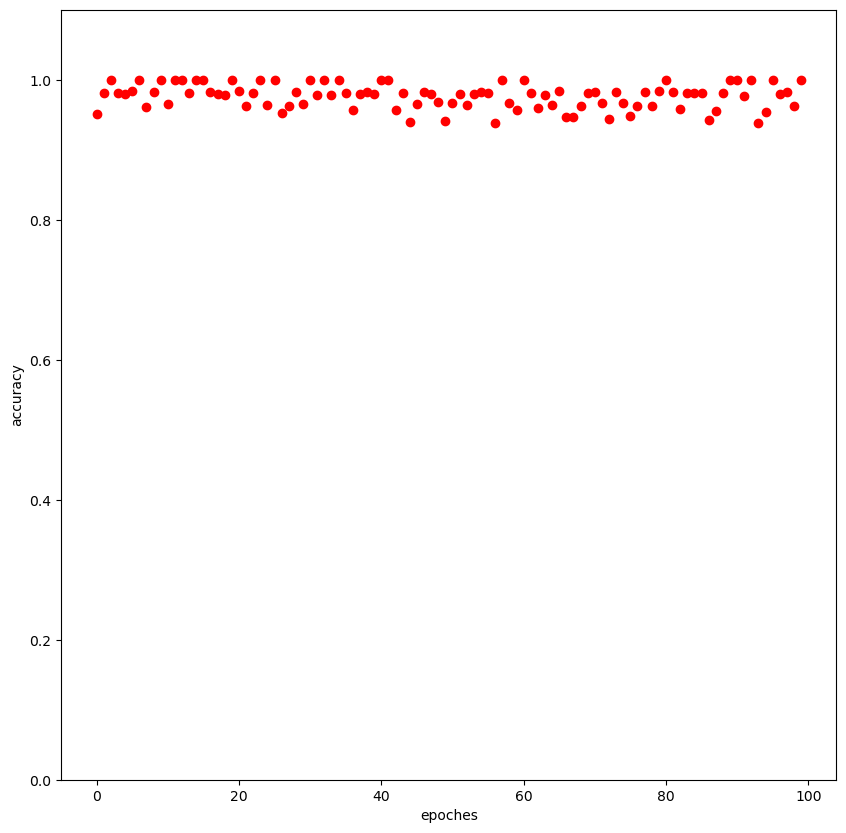

In [14]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize = (10,10))

index = range(len(all_saved_test_accs))
plt.scatter(index, all_saved_test_accs, label = "test acc", color = "r")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.ylim(0,1.1)

plt.savefig("models/randomforest_vggish_aug.png")
plt.show()

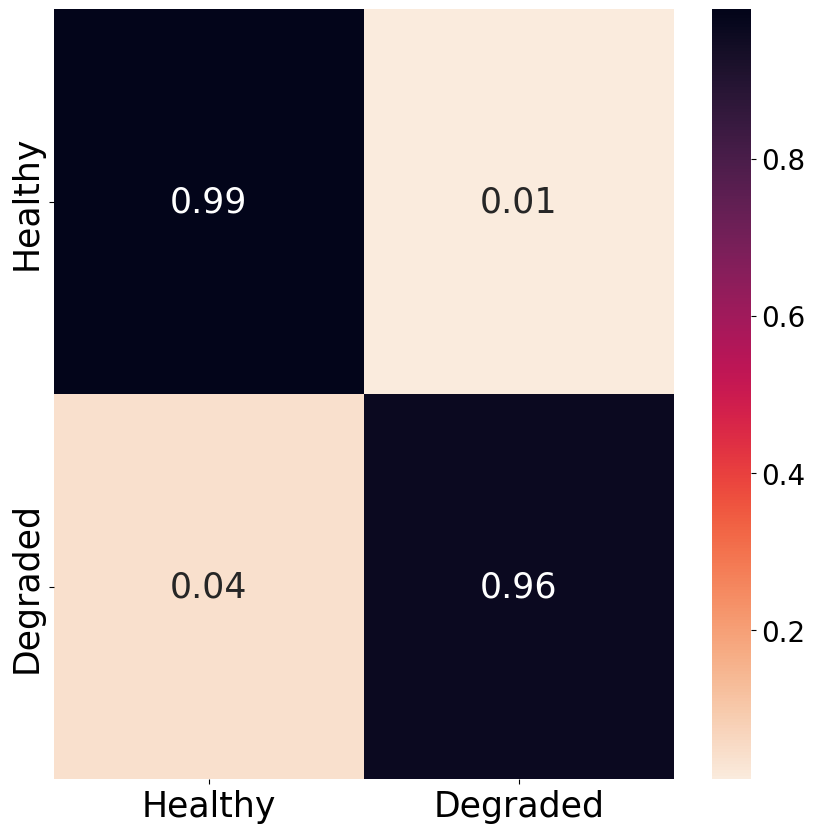

In [15]:
#HPC confusion amtrix was: [[21008.,  2572.],
 #[ 2954., 20101.]]

# array = ConfusionMatrix
array = np.around(ConfusionMatrix.astype('float') / ConfusionMatrix.sum(axis=1)[:, np.newaxis],2)


df_cm = pd.DataFrame(array, index = ['Healthy', 'Degraded'], #i for i in "AB"],
                  columns = ['Healthy', 'Degraded'])#[i for i in "AB"])
plt.figure(figsize = (10,10))
cmap = sn.cm.rocket_r
ax = sn.heatmap(df_cm, annot=True, annot_kws={"fontsize":25}, fmt='g', cmap = cmap)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 25)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 25)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.savefig("models/vgg_randomforest_aug.png")